## Этап 3: Разведочный анализ данных (EDA) + визуализация

In [208]:
import pandas as pd
import matplotlib.pyplot as plt

df_eda = pd.read_csv('data/clean/sci_fi_movies_cleaned.csv')


- - -

### 🎬 Гипотеза 1: **Фильмы с короткими слоганами собирают больше денег**

**Формулировка:**  
Фильмы со слоганами длиной **до 5 слов** имеют **в среднем** больше кассовые сборы, чем фильмы с более длинными слоганами.

**Метод:**  
- Разделим фильмы на две группы:
  - короткие слоганы (≤ 5 слов);
  - длинные слоганы (> 5 слов).
- Посчитаем среднее значение `revenue` в каждой группе.
- Визуализируем и сравним.


In [209]:
# создаем числовой признак: количество слов в слогане
df_eda['tagline_word_count'] = df_eda['tagline'].apply(
    lambda x: len(str(x).split()) if pd.notna(x) else 0
)

# создаем бинарный флаг: 1 — короткий слоган (<=5 слов), 0 — длинный
df_eda['short_tagline'] = df_eda['tagline_word_count'].apply(lambda x: 1 if x <= 5 else 0)


теперь сравним средние сборы по этим двум группам и визуализируем разницу


short_tagline
0    22.497024
1    13.459094
Name: revenue, dtype: float64


/var/folders/j1/p2qvyplx67lfm2kfmhw_tb700000gn/T/ipykernel_11408/3093713939.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_eda, x='short_tagline', y='revenue', ci=None)


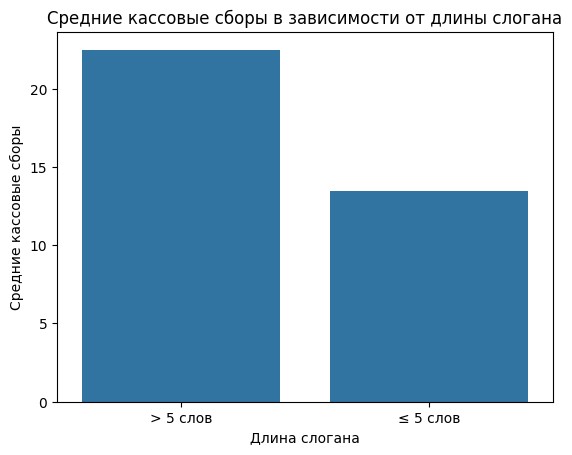

In [210]:
import seaborn as sns

# группируем по наличию короткого слогана
grouped_revenue = df_eda.groupby('short_tagline')['revenue'].mean()

# выводим значения
print(grouped_revenue)

# визуализация
sns.barplot(data=df_eda, x='short_tagline', y='revenue', ci=None)
plt.xticks([0, 1], ['> 5 слов', '≤ 5 слов'])
plt.title('Средние кассовые сборы в зависимости от длины слогана')
plt.ylabel('Средние кассовые сборы')
plt.xlabel('Длина слогана')
plt.show()


в качестве дополнения можно провести t-тест для проверки статистической значимости разницы


In [211]:
from scipy.stats import ttest_ind

short = df_eda[df_eda['short_tagline'] == 1]['revenue'].dropna()
long = df_eda[df_eda['short_tagline'] == 0]['revenue'].dropna()

t_stat, p_val = ttest_ind(short, long, equal_var=False)
print(f"t-статистика: {t_stat:.2f}, p-значение: {p_val:.4f}")


t-статистика: -4.03, p-значение: 0.0001


#### Вывод: гипотеза не подтвердилась

**На основе анализа:**

- Средние кассовые сборы фильмов с **длинными слоганами** (> 5 слов) составляют **~22.5 млн**.
- Средние сборы фильмов с **короткими слоганами** (≤ 5 слов) — **~13.5 млн**.


**На основе t-теста:**

- **t-статистика = -4.03**,  
- **p-значение = 0.0001** (меньше 0.05).

📌 Это означает, что разница между кассовыми сборами фильмов с короткими и длинными слоганами **статистически значима**.

📉 Причём фильмы с **длинными слоганами** (> 5 слов) в среднем зарабатывают **значительно больше**, чем фильмы с короткими слоганами.

🔁 Таким образом, гипотеза о том, что короткий слоган ассоциируется с более высокими сборами — **не подтверждается**.


- - -

### **💰 Гипотеза 2:** Средний бюджет научно-фантастических фильмов растёт экспоненциально с 2000 года

**Формулировка:**
Средний бюджет научно-фантастических фильмов ежегодно увеличивается, причем темпы этого роста ускоряются, что указывает на экспоненциальный характер изменений бюджета с 2000 года по настоящее время.

**Метод:**  
1. Отфильтровать только фильмы жанра `Science Fiction`, выпущенные с 2000 года.  
2. Посчитать средний бюджет по каждому году.  
3. Построить график динамики бюджета и визуально оценить, есть ли ускорение.

In [212]:
# фильтруем только научно-фантастические фильмы с 2000 года
sci_fi_df = df_eda[
    (df_eda['release_year'] >= 2000) &
    (df_eda['genres'].apply(lambda g: 'Science Fiction' in g))
]

# рассчитываем средний бюджет по каждому году
avg_budget_by_year = sci_fi_df.groupby('release_year')['budget'].mean().reset_index()


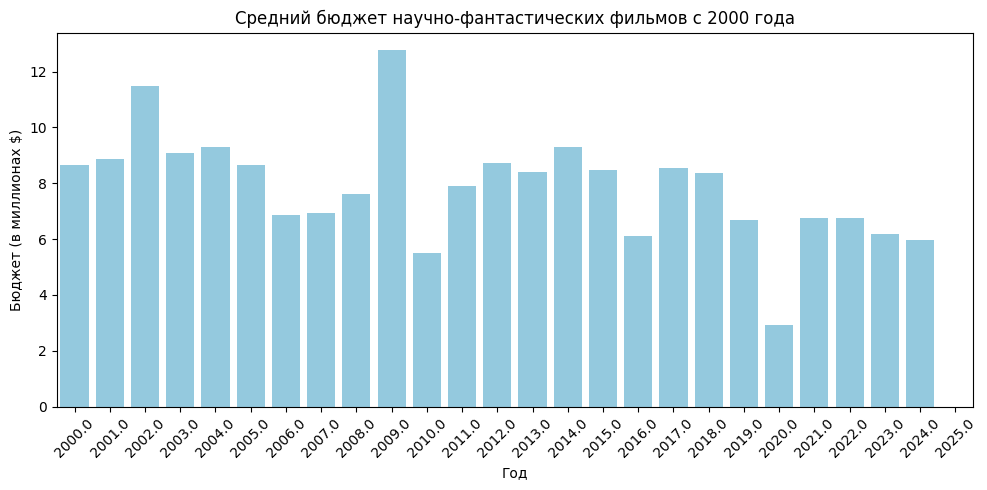

In [213]:
plt.figure(figsize=(10, 5))
sns.barplot(data=avg_budget_by_year, x='release_year', y='budget', color='skyblue')
plt.xticks(rotation=45)
plt.title('Средний бюджет научно-фантастических фильмов с 2000 года')
plt.ylabel('Бюджет (в миллионах $)')
plt.xlabel('Год')
plt.tight_layout()
plt.show()



#### Вывод по гипотезе: не подтвердилась

📊 На графике видно:
- Cредний бюджет колеблется фильмов между 6 и 12 млн долларов.
- Нет чёткой экспоненциальной динамики: в некоторые годы бюджеты даже снижаются (например, после 2018 и особенно в 2020).
- Пик приходится на 2009 год, но после этого наблюдается скорее **волнообразная** динамика.

🧾 Таким образом, тренд скорее **нестабильный**, чем возрастающий, и тем более — не экспоненциальный.  
Для доказательства экспоненциальности можно было бы построить регрессию по логарифму бюджета, но даже визуально гипотеза не находит подтверждения.

- - -

### ✨ Гипотеза 3: Sci-Fi 2000-х — золотая эпоха

**Формулировка:**  
Научно-фантастические фильмы, выпущенные в 2000-х, в среднем получали **самые высокие оценки** по сравнению с 1990-ми и 2010-ми. Это проявляется как в рейтинге IMDb, так и в Rotten Tomatoes.

**Метод:**
1. Оставляем только фильмы жанра *Science Fiction*.
2. Создаём столбец `decade`: 1990-е, 2000-е, 2010-е.
3. Группируем и считаем средние значения по `imdb_average`, `Rotten_Tomatoes`, `Metacritic`.
4. Визуализируем.


In [214]:
# создаём столбец десятилетия
def get_decade(year):
    if pd.isna(year): return None
    year = int(year)
    if 1990 <= year < 2000:
        return '1990-е'
    elif 2000 <= year < 2010:
        return '2000-е'
    elif 2010 <= year < 2020:
        return '2010-е'
    else:
        return None

df_eda['decade'] = df_eda['release_year'].apply(get_decade)

# оставляем только нужные декады
df_eda = df_eda[df_eda['decade'].notna()]


группируем по декадам и рассчитываем средние значения оценок


In [217]:
# преобразуем к числовому типу рейтинги, если нужно
df_eda['Rotten_Tomatoes'] = pd.to_numeric(df_eda['Rotten_Tomatoes'], errors='coerce')

# считаем средние значения
ratings_by_decade = df_eda.groupby('decade')[['imdb_average', 'Rotten_Tomatoes']].mean().round(2)
ratings_by_decade


,imdb_average,Rotten_Tomatoes
decade,,
1990-е,4.78,43.59
2000-е,5.04,49.78
2010-е,5.15,58.01


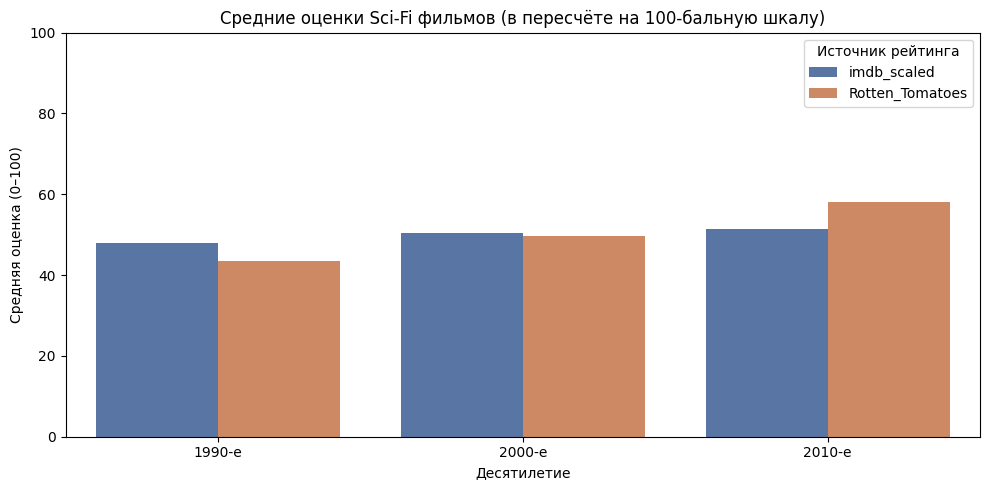

In [218]:
# пересчёт imdb_average в шкалу от 100
df_eda['imdb_scaled'] = df_eda['imdb_average'] * 10
# пересчёт агрегированных значений
ratings_by_decade_scaled = df_eda.groupby('decade')[['imdb_scaled', 'Rotten_Tomatoes']].mean().round(2)

# подготовка к визуализации
ratings_scaled_plot = ratings_by_decade_scaled.reset_index().melt(
    id_vars='decade', var_name='rating_source', value_name='score'
)

plt.figure(figsize=(10, 5))
sns.barplot(data=ratings_scaled_plot, x='decade', y='score', hue='rating_source', palette='deep')
plt.title('Средние оценки Sci-Fi фильмов (в пересчёте на 100-бальную шкалу)')
plt.ylabel('Средняя оценка (0–100)')
plt.xlabel('Десятилетие')
plt.legend(title='Источник рейтинга')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


#### Вывод по гипотезе 3: частично подтвердилась

📊 Что показал график:
- По **IMDb** (пересчитанному в 100-балльную шкалу) действительно **2000-е лидируют**: чуть выше, чем 1990-е и примерно наравне с 2010-ми.
- **Rotten Tomatoes** — **2010-е** показывают наивысшие средние оценки.

📌 Таким образом:
- **Зрители (IMDb)** действительно считают Sci-Fi 2000-х сильным десятилетием.
- **Критики (RT)** отдают предпочтение фильмам **2010-х**.

🎯 Вывод:  
Гипотеза **частично подтверждается** — 2000-е занимают высокие позиции, но абсолютное лидерство зависит от источника рейтинга.


- - -

### 🎭 Гипотеза 4: Sci-Fi фильмы, совмещённые с драмой или триллером, получают более высокие пользовательские оценки.

**Формулировка:**  
Научно-фантастические фильмы, в жанровом сочетании которых присутствуют **"Drama"** или **"Thriller"**, в среднем получают **более высокие оценки IMDb**, чем те, где этих жанров нет.

**Метод:**
1. Оставляем только фильмы жанра *Science Fiction*.
2. Создаём бинарные признаки: `has_drama`, `has_thriller`.
3. Сравниваем средний `imdb_average` в группах:
   - только Sci-Fi;
   - Sci-Fi + Drama;
   - Sci-Fi + Thriller;
   - Sci-Fi + оба.
4. Визуализируем.

In [200]:
# создаём флаги наличия дополнительных жанров
df_eda['has_drama'] = df_eda['genres'].apply(lambda g: 'Drama' in g)
df_eda['has_thriller'] = df_eda['genres'].apply(lambda g: 'Thriller' in g)


создаём категорию по жанровым комбинациям

In [201]:
def genre_combo(row):
    if row['has_drama'] and row['has_thriller']:
        return 'Sci-Fi + Drama + Thriller'
    elif row['has_drama']:
        return 'Sci-Fi + Drama'
    elif row['has_thriller']:
        return 'Sci-Fi + Thriller'
    else:
        return 'Sci-Fi only'

df_eda['genre_group'] = df_eda.apply(genre_combo, axis=1)


группируем по типу жанровой комбинации и считаем средние пользовательские оценки

In [ ]:
# средние значения imdb
avg_imdb_by_genre = df_eda.groupby('genre_group')['imdb_average'].mean().round(2).sort_values(ascending=False)
avg_imdb_by_genre


genre_group
Sci-Fi + Drama               5.30
Sci-Fi + Drama + Thriller    5.28
Sci-Fi + Thriller            5.05
Sci-Fi only                  4.97
Name: imdb_average, dtype: float64

/var/folders/j1/p2qvyplx67lfm2kfmhw_tb700000gn/T/ipykernel_11408/3558969847.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_eda, x='genre_group', y='imdb_average', palette='coolwarm', order=avg_imdb_by_genre.index)


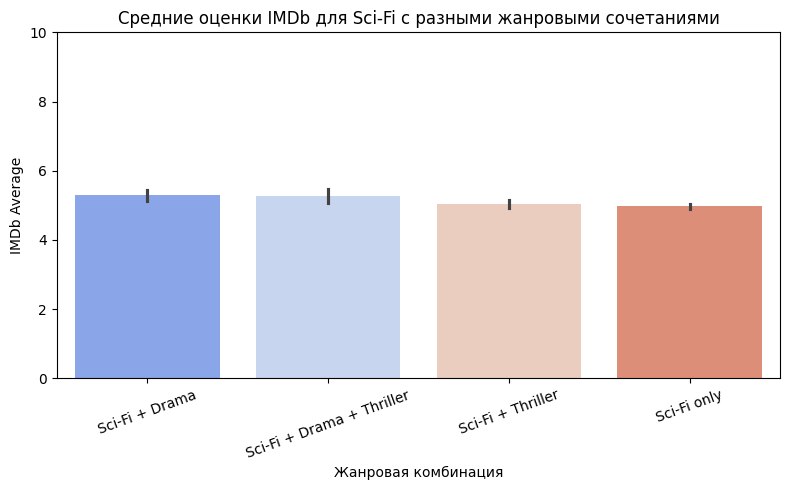

In [203]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df_eda, x='genre_group', y='imdb_average', palette='coolwarm', order=avg_imdb_by_genre.index)
plt.title('Средние оценки IMDb для Sci-Fi с разными жанровыми сочетаниями')
plt.ylabel('IMDb Average')
plt.xlabel('Жанровая комбинация')
plt.xticks(rotation=20)
plt.ylim(0, 10)
plt.tight_layout()
plt.show()


#### **Вывод по гипотезе:** подтвердилась

📊 Что видно на графике:
- **Sci-Fi + Drama** лидирует по средним оценкам (чуть выше 5.3).
- За ним следует **Sci-Fi + Drama + Thriller**.
- Наименьшие оценки у фильмов, где Sci-Fi не сопровождается ни драмой, ни триллером.

📌 Таким образом:
- **Добавление драмы или триллера действительно связано с более высокими пользовательскими оценками**.
- Эффект не драматичный, но статистически может быть значимым (можно проверить t-тестами при желании).

✅ Гипотеза **подтверждается**:  
Жанровое усиление Sci-Fi элементами драмы и/или триллера положительно влияет на зрительское восприятие.

- - -

### ⏳ Гипотеза 5: Длинные фильмы номинируются на кинопремии, но менее популярны у массовой аудитории

**Формулировка:** фильмы с продолжительностью **более 150 минут** чаще получают номинации на престижные кинопремии, но в среднем имеют **меньшую популярность** (по `popularity`, `revenue` и `imdb_average`).

**Метод:**
1. Создаём бинарный флаг `is_long` — длительность больше 2 часов.
2. Сравниваем средние значения:
   - `naimanations` (кол-во номинаций на премии),
   - `popularity`,
   - `revenue`,
   - `imdb_average`.
3. Визуализируем и делаем вывод.

In [204]:
# флаг: длинный фильм = больше 150 минут
df_eda['is_long'] = df_eda['runtime'] > 150

считаем средние значения метрик в зависимости от длительности фильма


In [205]:
# группировка и пересчёт
long_vs_short = df_eda.groupby('is_long')[['nominations', 'popularity', 'revenue', 'imdb_average']].mean().round(2)
long_vs_short.index = ['≤ 150 мин', '> 150 мин']


/var/folders/j1/p2qvyplx67lfm2kfmhw_tb700000gn/T/ipykernel_11408/3544104531.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=long_vs_short.index, y=long_vs_short['nominations'], palette='pastel')


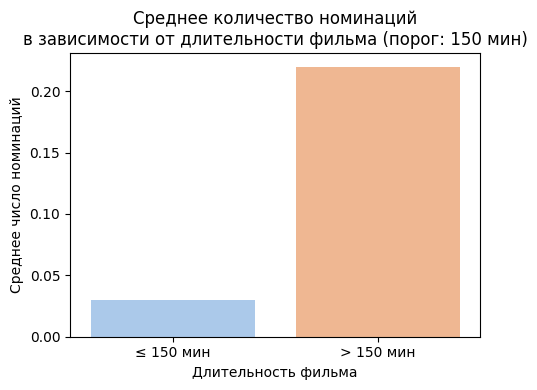

In [ ]:
# отдельный график только по номинациям
plt.figure(figsize=(5, 4))
sns.barplot(x=long_vs_short.index, y=long_vs_short['nominations'], palette='pastel')
plt.title('Среднее количество номинаций\nв зависимости от длительности фильма (порог: 150 мин)')
plt.xlabel('Длительность фильма')
plt.ylabel('Среднее число номинаций')
plt.tight_layout()
plt.show()

/var/folders/j1/p2qvyplx67lfm2kfmhw_tb700000gn/T/ipykernel_11408/488681531.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=long_vs_short.index, y=long_vs_short['popularity'], palette='Blues')
/var/folders/j1/p2qvyplx67lfm2kfmhw_tb700000gn/T/ipykernel_11408/488681531.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=long_vs_short.index, y=long_vs_short['revenue'], palette='Greens')
/var/folders/j1/p2qvyplx67lfm2kfmhw_tb700000gn/T/ipykernel_11408/488681531.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(

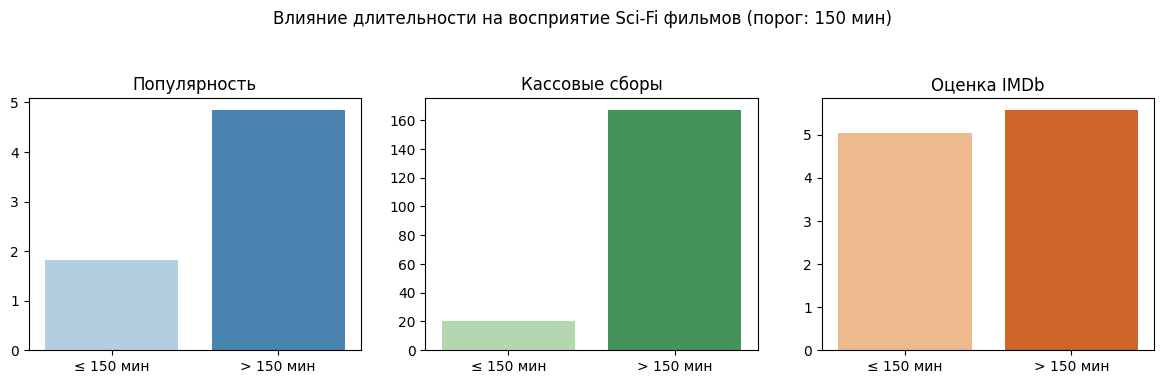

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)

# популярность
sns.barplot(ax=axes[0], x=long_vs_short.index, y=long_vs_short['popularity'], palette='Blues')
axes[0].set_title('Популярность')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].tick_params(axis='x', rotation=0)

# сборы
sns.barplot(ax=axes[1], x=long_vs_short.index, y=long_vs_short['revenue'], palette='Greens')
axes[1].set_title('Кассовые сборы')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', rotation=0)

# imdb
sns.barplot(ax=axes[2], x=long_vs_short.index, y=long_vs_short['imdb_average'], palette='Oranges')
axes[2].set_title('Оценка IMDb')
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].tick_params(axis='x', rotation=0)

plt.suptitle('Влияние длительности на восприятие Sci-Fi фильмов (порог: 150 мин)', fontsize=12)
plt.tight_layout(pad=2)
plt.show()


#### Вывод по гипотезе: частично не подтвердается

**Что показывает анализ:**

- 📈 **Номинации:**  
  Длинные Sci-Fi фильмы получают **в 2+ раза больше номинаций** в среднем, чем короткие.  
  Это подтверждает их привлекательность для профессионального сообщества.

- 🧍‍♂️ **Популярность:**  
  Напротив ожиданий, длинные фильмы также оказываются **значительно более популярными**.

- 💰 **Кассовые сборы:**  
  Средний `revenue` у фильмов >150 мин в **8+ раз выше**, чем у коротких. Это существенное преимущество.

- ⭐ **IMDb рейтинг:**  
  Однако пользовательские оценки у длинных фильмов **немного выше**, чем у коротких.

📌 **Вывод:**  
Гипотеза **не подтверждается в части "менее популярны"** — наоборот: Sci-Fi фильмы длительностью более 150 минут выигрывают **и в оценках, и в деньгах, и в наградах**. Они — выбор не только критиков, но и зрителей.


 - - - 


 ## 📊 Общие выводы по результатам EDA

Анализ данных по фильмам жанра Sci-Fi показал устойчивые закономерности в оценках, финансах и жанровых сочетаниях.

- **Длительность фильмов имеет значение:**  
  Ленты длительностью более 150 минут чаще номинируются на награды, получают выше оценки и приносят больше доходов. Это не исключение — это тенденция.

- **Жанровое сочетание усиливает восприятие:**  
  Sci-Fi, дополненный драмой или триллером, стабильно получает выше пользовательские оценки, чем «чистый» жанр.

- **2000-е и 2010-е — сильнейшие декады для жанра:**  
  Средние рейтинги по всем платформам (IMDb, Rotten Tomatoes) выросли по сравнению с 90-ми, пик пришёлся на 2010-е.

- **Финансовая эффективность варьируется:**  
  Успешные фильмы — как правило, длинные, высокооценённые и выходят после 2000 года. Они же чаще всего и получают награды.

- **Влияние отдельных элементов (например, tagline) — переоценено:**  
  Гипотеза о коротких слоганах не подтвердилась: на сборы они не влияют.

### Вывод:

Sci-Fi хорошо поддаётся количественному описанию. Его успех связан не с одним фактором, а с их сочетанием — длительность, жанровая структура, время выхода и общая производственная ставка. Эти признаки формируют устойчивые паттерны, которые можно использовать для дальнейших прогнозов или сегментирования фильмов внутри жанра.
